In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import warnings
import math as m
import time
from scipy import linalg 
from scipy.linalg import hadamard
warnings.filterwarnings("ignore")

# Implementing sketching on a Random matrix and vector

In [2]:
A=np.random.choice(list(range(0,10000)),[4096,3])
b=np.random.choice(list(range(0,10000)),[4096,1])#Each having row dimension in the power of 2,hence exact Hadamard Transform will exist.

# Leverage scores_exact

In [3]:
def Leverage_scores_exact(A):
    ''' Exact leverage score computation
        Input
            A:n-by-d matrix 
        Output
            leverage_scores: Vector containing the leverage scores ( L-2 norm of U(i,:)) where A=U(SIGMA)V*,the SVD of A
    '''
    U,_,_=linalg.svd(A, full_matrices=False)
    leverage_scores = np.linalg.norm(U , axis=1)
    return leverage_scores


In [4]:
Exact_leverage=Leverage_scores_exact(A)

In [5]:
Exact_leverage

array([0.03192333, 0.02065298, 0.02590586, ..., 0.02141929, 0.03381057,
       0.01248467])

# Sketching Techniques

# Uniform_sketching

In [6]:
def uniform_sketching(A,r):
    '''
    Uniform Sketching
    Input
        1.A: n-by-d dense matrix (n>>d)
        2.r: sketch size
    Procedure
        1.Compute the SVD decomposition of A=U(SIGMA)V*
        2.Compute the row L-2 norms of U
    Output
        sketch_A: r-by-d matrix 
    '''
    n=A.shape[0]                                
    index = np.random.choice(n,r, replace=True)
    B = A[index,:] * (n / r)                    
    return B

In [7]:
Sketched_A=uniform_sketching(A,1000)
Sketched_A.shape

(1000, 3)

# Gaussian Projection

In [8]:
def gaussian_projection(A,r):
    '''
    Random Gaussian Projection
    
    Input
        1.A: n-by-d dense matrix A
        2.r: sketch size
    Procedure
        1.Construct r-by-n Sampling matrix S, where each entry of S is from a standard normal distribution
        2.Compute S*A 
    Output
        sketch_A: r-by-d matrix S*A
        Here S is r-by-n sketching matrix
    '''
    n= A.shape[0]                        
    S = np.random.randn(r,n) / np.sqrt(r)
    sketch_A = np.dot(S,A)               
    return sketch_A

In [9]:
Sketched_A=gaussian_projection(A,1000)
Sketched_A.shape

(1000, 3)

# Concern for Hadamard matrix

In the following two code snippets we compute a Hadamard matrix for implementing Subsampled Randomized Hadamard Transformation(SRHT), now it is well known that a Hadamard matrix only exists for order in the power of 2. Now we face the problem that the concerned matrix A on which the transform is to be applied may not have the corresponding dimension n, dimension of row (or column along which the transformation is to be applied) in the power of 2, we don't have a Hadamard matrix of such order. To deal with it,here we compute the nearest greater integer to n which is a power of 2, say k, and then append (k-n) null rows to A and then proceed for the SHRT of A.

# Uniform Subsampled Randomized Hadamard Transform

In [10]:
def uniform_SRHT(A,b,epsilon):#epsilon >0 such that the sketching size do not blow up and become more than row dimension of A.
    '''
       Subsampled Randomized Hadamard Transform(Uniform)
       Input
           1.A: n-by-d dense matrix A
           2.b: n-by-1 dense vector b
           3.epsilon: error allowence
       Procedure:
           1.Compute Hadamard matrix H
           2.Normalize H
           3.Compute diagonal matrix D, the diagonal entries are independent Rademacher random variables
           4.Compute R the sparsified random projection matrix, here R is constructed using uniform distribution
           5.Compute RHD, the randomized hadamard transform matrix
           6.Compute RHD*A and RHD*b
       Output
           1.A_hat: The Sketched r-by-d matrix
           2.The SRHT r-by-n sampling matrix
           3.b: A vector which will be same as the input b if n is a power of 2
    '''
    n=A.shape[0]
    if epsilon<=1:
        r=int(np.ceil(A.shape[1]*(pow(m.log(n),3)/pow(epsilon,2))))
    else:
        r=int(np.ceil(A.shape[1]*(pow(m.log(n),3))))
    if r>=n:
        print("No reduction of dimensionality, enter a new epsilon")
        return
    n_hat=int((pow(2,np.ceil(m.log2(n))))) 
    res=n_hat-n
    A_hat=list(A)
    b_hat=list(b)
    for i in range(res):
        A_hat+=[np.zeros([1,A.shape[1]])]
        b_hat+=[np.zeros(1)]
    A=np.vstack(A_hat)
    b=np.vstack(b_hat)
    H=hadamard(n_hat)*(1/np.sqrt(n_hat))
    D=np.diag(np.random.choice([-1,1],n_hat,p=None))
    R=np.zeros([r,n_hat])
    k=np.random.choice(n,r,replace=True,p=None)
    for i in range(len(R)):
        R[i][k[i]]=1/np.sqrt(r/n)
    A_hat=np.matmul(np.matmul(R,np.matmul(H,D)),A)
    return A_hat, np.matmul(R,np.matmul(H,D)),b

In [11]:
B=uniform_SRHT(A,b,0.7)

In [12]:
B

(array([[-5660.36703015, -1698.25497973, -2404.58377632],
        [ 5502.28953367,  3800.12641465,  9335.50036894],
        [13887.94359866, 10327.66238806,  9504.79692047],
        ...,
        [ 6941.79873912,  3705.89309034,  8157.29744284],
        [-2032.56934408, -3291.52925207, -3342.70566238],
        [ 2641.16096734,  3966.92984284,   914.16768742]]),
 array([[-0.01684543,  0.01684543,  0.01684543, ...,  0.01684543,
          0.01684543,  0.01684543],
        [-0.01684543,  0.01684543,  0.01684543, ...,  0.01684543,
          0.01684543,  0.01684543],
        [-0.01684543,  0.01684543,  0.01684543, ...,  0.01684543,
          0.01684543,  0.01684543],
        ...,
        [-0.01684543,  0.01684543, -0.01684543, ...,  0.01684543,
         -0.01684543, -0.01684543],
        [-0.01684543,  0.01684543, -0.01684543, ...,  0.01684543,
         -0.01684543, -0.01684543],
        [-0.01684543, -0.01684543, -0.01684543, ...,  0.01684543,
          0.01684543, -0.01684543]]),
 array([[1

In [13]:
B[0].shape

(3524, 3)

# Non-unniform Subsampled Randomized Hadamard Transform

In [14]:
def SRHT(A,b,epsilon):#epsilon >0 such that the sketching size do not blow up and become more than row dimension of A
    '''
       Subsampled Randomized Hadamard Transform(Non-Uniform)
       Input
           1.A: n-by-d dense matrix A
           2.b: n-by-1 dense vector b
           3.epsilon: error allowence
       Procedure:
           1.Compute Hadamard matrix H
           2.Normalize H
           3.Compute diagonal matrix D, the diagonal entries are independent Rademacher random variables
           4.Compute R the sparsified random projection matrix, here R is constructed using leverage probability sampling
           5.Compute RHD, the randomized hadamard transform matrix
           6.Compute RHD*A and RHD*b
       Output
           1.A_hat: The Sketched r-by-d matrix
           2.The SRHT r-by-n sampling matrix
           3.b: A vector which will be same as the input b in n is a power of 2
    '''
    n=A.shape[0]
    if epsilon<=1:
        r=int(np.ceil(A.shape[1]*(pow(m.log(n),3)/pow(epsilon,2))))
    else:
        r=int(np.ceil(A.shape[1]*(pow(m.log(n),3))))
    if r>=n:
        print("No reduction of dimensionality, enter a new epsilon")
        return 
    n_hat=int((pow(2,np.ceil(m.log2(n)))))
    res=n_hat-n
    leverage_scores=Leverage_scores_exact(A)
    #leverage_scores=approx_leverage_scores(A,b,epsilon)
    leverage_probability=[]
    leverage_probability=leverage_scores/sum(leverage_scores)
    A_hat=list(A)
    b_hat=list(b)
    for i in range(res):
        A_hat+=[np.zeros([1,A.shape[1]])]
        b_hat+=[np.zeros(1)]
    A=np.vstack(A_hat)
    b=np.vstack(b_hat)
    H=hadamard(n_hat)*(1/np.sqrt(n_hat))
    D=np.diag(np.random.choice([-1,1],n_hat,p=None))
    R=np.zeros([r,n_hat]) 
    k=np.random.choice(n,r,replace=True,p=leverage_probability)
    for i in range(len(R)):
        R[i][k[i]]=1/np.sqrt(leverage_probability[k[i]]*r)
    A_hat=np.matmul(np.matmul(R,np.matmul(H,D)),A)
    return A_hat, np.matmul(R,np.matmul(H,D)),b

In [15]:
B=SRHT(A,b,0.7)

In [16]:
B

(array([[ -2189.31727564,  -4802.54698207, -13530.14773416],
        [  1625.48035868,  -6774.01257498,  -2033.00190651],
        [ -2495.89562067,  -2655.54582246,  -3300.97746714],
        ...,
        [-14298.25918791, -11989.0868249 ,  -3007.31639337],
        [  8452.69629147,   9893.74368933,   5329.80029141],
        [-15277.15237018,  -8640.9511231 ,  -9854.6434671 ]]),
 array([[ 0.01724904, -0.01724904,  0.01724904, ..., -0.01724904,
          0.01724904, -0.01724904],
        [ 0.0157734 , -0.0157734 , -0.0157734 , ..., -0.0157734 ,
         -0.0157734 ,  0.0157734 ],
        [ 0.01649961, -0.01649961, -0.01649961, ..., -0.01649961,
         -0.01649961,  0.01649961],
        ...,
        [ 0.01701048,  0.01701048, -0.01701048, ...,  0.01701048,
         -0.01701048, -0.01701048],
        [ 0.01435049, -0.01435049,  0.01435049, ...,  0.01435049,
         -0.01435049,  0.01435049],
        [ 0.01444115, -0.01444115, -0.01444115, ...,  0.01444115,
          0.01444115, -0.01444

In [17]:
B[0].shape

(3524, 3)

In [18]:
def approx_leverage_scores(A,b,epsilon):
    ''' Approximation of leverage score
        Input
            1.A:n-by-d matrix 
            2.b:n-by-d matrix, since here uniform_SRHT used, this is an argument though and can be 
                ignored by changing uniform_SRHT a bit
            3.epsilon: error allowence
        Procedure
            1.Compute SRHT(uniform) of A, A1 say
            2.Compute SRHT(uniform) of A1, A2 say
            3.Compute Moore–Penrose inverse (generalized inverse) of A2,A3 say
            4.Compute A*A3
            5.Approximate U by A*A3
            6.Compute leverage scores
        Output
            leverage_scores: Vector containing the leverage scores approximated as L-2 norm of (A*A3)(i,:)
    '''
    A1,_,_=uniform_SRHT(A,b,epsilon)
    A2,_,_=uniform_SRHT(A1,b,epsilon)
    A3=np.linalg.pinv(A2)
    new_A=np.matmul(A,A3)
    leverage_scores = np.linalg.norm(new_A, axis=1)
    return leverage_scores

In [19]:
approx_leverage=approx_leverage_scores(A,b,0.8)

In [20]:
approx_leverage

array([0.03986953, 0.02600278, 0.03265746, ..., 0.02727732, 0.04294368,
       0.01632167])

#  L2-norm difference between Exact and approximated leverage score

In [21]:
np.linalg.norm(Exact_leverage-approx_leverage)

0.45959238559331794

# Implementation on the Advertisement Dataset

In [22]:
df=pd.read_csv("Advertising.csv")

In [23]:
df.shape

(200, 5)

In [24]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [25]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [26]:
Sales=df['sales'].as_matrix()
TV=df['TV'].as_matrix()

In [27]:
TV=TV.reshape(TV.shape[0],1)

In [28]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt

# TV vs sales

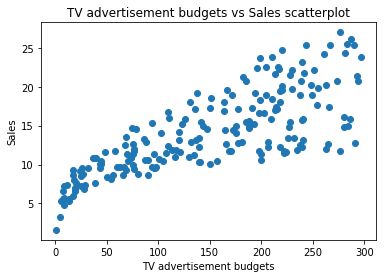

In [29]:
plt.scatter(TV,Sales)
plt.title('TV advertisement budgets vs Sales scatterplot')
plt.xlabel('TV advertisement budgets')
plt.ylabel('Sales')
plt.savefig('TV_sales_scatter.png', bbox_inches='tight')
plt.show()

In [30]:
x_ls,residual,_,_=np.linalg.lstsq(TV,Sales, rcond=None)
print("The solution by classical least square method is",x_ls[0])
print("The residual due to the use of the method of least square is", residual[0])

The solution by classical least square method is 0.08324960871677155
The residual due to the use of the method of least square is 4607.919335907738


For epsilon = 0.89

In [31]:
B=SRHT(TV,Sales,0.89)
x_rls,_,_,_=np.linalg.lstsq(B[0],np.matmul(B[1],B[2]),rcond=None)
residual=np.linalg.norm(np.matmul(TV,x_rls)-Sales)
print("The solution by using SRHT sketching on the least square problem is",x_rls[0][0])
print("The residual due to the use of SRHT sketching on the least square problem is", residual)

The solution by using SRHT sketching on the least square problem is 0.08683630445933657
The residual due to the use of SRHT sketching on the least square problem is 1832.604768762272


In [32]:
print('The L-2 difference measure between the solution of the two vectors is',np.linalg.norm(x_rls-x_ls))

The L-2 difference measure between the solution of the two vectors is 0.003586695742565024


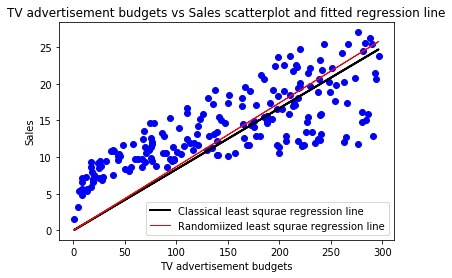

In [33]:
# Plot
plt.scatter(TV,Sales, color='blue')
plt.plot(TV,np.matmul(TV,x_ls), color='black', linewidth=2,label='Classical least squrae regression line')
plt.plot(TV,np.matmul(TV,x_rls), color='red', linewidth=1,label='Randomiized least squrae regression line')
plt.title('TV advertisement budgets vs Sales scatterplot and fitted regression line')
plt.xlabel('TV advertisement budgets')
plt.ylabel('Sales')
plt.xticks()
plt.yticks()
plt.legend()
plt.savefig('SRHTepsilonTV_point89.png', bbox_inches='tight')
plt.show()

For epsilon=0.9

In [34]:
B=SRHT(TV,Sales,0.9)
x_rls,_,_,_=np.linalg.lstsq(B[0],np.matmul(B[1],B[2]),rcond=None)
residual=np.linalg.norm(np.matmul(TV,x_rls)-Sales)
print("The solution by using SRHT sketching on the least square problem is",x_rls[0][0])
print("The residual due to the use of SRHT sketching on the least square problem is", residual)

The solution by using SRHT sketching on the least square problem is 0.08318024726899678
The residual due to the use of SRHT sketching on the least square problem is 1800.4373538704576


In [35]:
print('The L-2 difference measure between the solution of the two vectors is',np.linalg.norm(x_rls-x_ls))

The L-2 difference measure between the solution of the two vectors is 6.93614477747656e-05


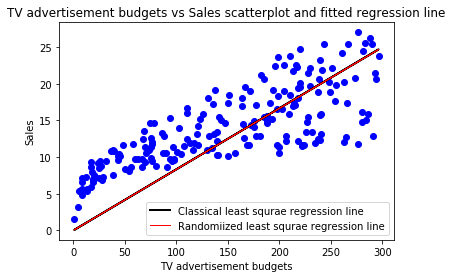

In [36]:
# Plot
plt.scatter(TV,Sales, color='blue')
plt.plot(TV,np.matmul(TV,x_ls), color='black', linewidth=2,label='Classical least squrae regression line')
plt.plot(TV,np.matmul(TV,x_rls), color='red', linewidth=1,label='Randomiized least squrae regression line')
plt.title('TV advertisement budgets vs Sales scatterplot and fitted regression line')
plt.xlabel('TV advertisement budgets')
plt.ylabel('Sales')
plt.xticks()
plt.yticks()
plt.legend()
plt.savefig('SRHTepsilonTV_point9.png', bbox_inches='tight')
plt.show()

 For epsilon=0.95

In [37]:
B=SRHT(TV,Sales,0.95)
x_rls,_,_,_=np.linalg.lstsq(B[0],np.matmul(B[1],B[2]),rcond=None)
residual=np.linalg.norm(np.matmul(TV,x_rls)-Sales)
print("The solution by using SRHT sketching on the least square problem is",x_rls[0][0])
print("The residual due to the use of SRHT sketching on the least square problem is", residual)

The solution by using SRHT sketching on the least square problem is 0.08673764866040011
The residual due to the use of SRHT sketching on the least square problem is 1831.6332126402206


In [38]:
print('The L-2 difference measure between the solution of the two vectors is',np.linalg.norm(x_rls-x_ls))

The L-2 difference measure between the solution of the two vectors is 0.0034880399436285625


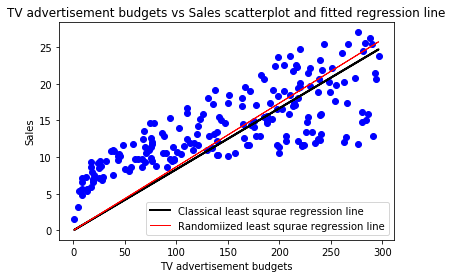

In [39]:
# Plot
plt.scatter(TV,Sales, color='blue')
plt.plot(TV,np.matmul(TV,x_ls), color='black', linewidth=2,label='Classical least squrae regression line')
plt.plot(TV,np.matmul(TV,x_rls), color='red', linewidth=1,label='Randomiized least squrae regression line')
plt.title('TV advertisement budgets vs Sales scatterplot and fitted regression line')
plt.xlabel('TV advertisement budgets')
plt.ylabel('Sales')
plt.xticks()
plt.yticks()
plt.legend()
plt.savefig('SRHTepsilonTV_point95.png', bbox_inches='tight')
plt.show()

# Newspaper vs sales

In [40]:
Newspaper=df['newspaper'].as_matrix()
Newspaper=Newspaper.reshape(Newspaper.shape[0],1)

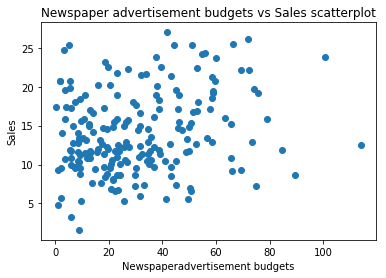

In [41]:
plt.scatter(Newspaper,Sales)
plt.title('Newspaper advertisement budgets vs Sales scatterplot')
plt.xlabel('Newspaperadvertisement budgets')
plt.ylabel('Sales')
plt.savefig('Newspaper_sales_scatter.png', bbox_inches='tight')
plt.show()

In [42]:
x_ls,residual,_,_=np.linalg.lstsq(Newspaper,Sales, rcond=None)
print("The solution by classical least square method is",x_ls[0])
print("The residual due to the use of the method of least square is", residual[0])

The solution by classical least square method is 0.32320200511752645
The residual due to the use of the method of least square is 15380.01493700745


For epsilon=0.9

In [43]:
B=SRHT(Newspaper,Sales,0.9)
x_rls,_,_,_=np.linalg.lstsq(B[0],np.matmul(B[1],B[2]),rcond=None)
residual=np.linalg.norm(np.matmul(Newspaper,x_rls)-Sales)
print("The solution by using SRHT sketching on the least square problem is",x_rls[0][0])
print("The residual due to the use of SRHT sketching on the least square problem is", residual)

The solution by using SRHT sketching on the least square problem is 0.33133025378912573
The residual due to the use of SRHT sketching on the least square problem is 1940.0754321940342


In [44]:
print("The solution by using SRHT sketching on the least square problem is",np.linalg.norm(x_rls-x_ls))

The solution by using SRHT sketching on the least square problem is 0.00812824867159928


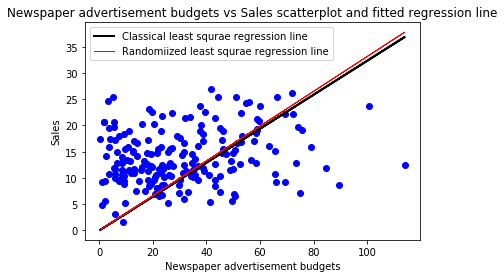

In [45]:
plt.scatter(Newspaper,Sales, color='blue')
plt.plot(Newspaper,np.matmul(Newspaper,x_ls), color='black', linewidth=2,label='Classical least squrae regression line')
plt.plot(Newspaper,np.matmul(Newspaper,x_rls), color='red', linewidth=1,label='Randomiized least squrae regression line')
plt.title('Newspaper advertisement budgets vs Sales scatterplot and fitted regression line')
plt.xlabel('Newspaper advertisement budgets')
plt.ylabel('Sales')
plt.xticks()
plt.yticks()
plt.legend()
plt.savefig('SRHTepsilonNews_point9.png', bbox_inches='tight')
plt.show()

For epsilon = 0.96

In [46]:
B=SRHT(Newspaper,Sales,0.96)
x_rls,_,_,_=np.linalg.lstsq(B[0],np.matmul(B[1],B[2]),rcond=None)
residual=np.linalg.norm(np.matmul(Newspaper,x_rls)-Sales)
print("The solution by using SRHT sketching on the least square problem is",x_rls[0][0])
print("The residual due to the use of SRHT sketching on the least square problem is", residual)

The solution by using SRHT sketching on the least square problem is 0.3871761002470231
The residual due to the use of SRHT sketching on the least square problem is 2026.224189035739


In [47]:
print("The solution by using SRHT sketching on the least square problem is",np.linalg.norm(x_rls-x_ls))

The solution by using SRHT sketching on the least square problem is 0.06397409512949664


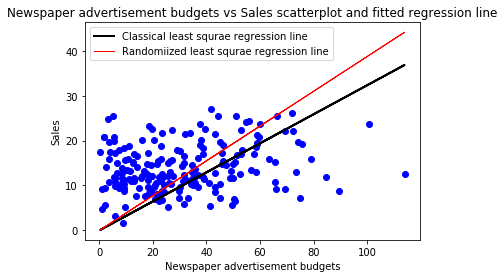

In [48]:
plt.scatter(Newspaper,Sales, color='blue')
plt.plot(Newspaper,np.matmul(Newspaper,x_ls), color='black', linewidth=2,label='Classical least squrae regression line')
plt.plot(Newspaper,np.matmul(Newspaper,x_rls), color='red', linewidth=1,label='Randomiized least squrae regression line')
plt.title('Newspaper advertisement budgets vs Sales scatterplot and fitted regression line')
plt.xlabel('Newspaper advertisement budgets')
plt.ylabel('Sales')
plt.xticks()
plt.yticks()
plt.legend()
plt.savefig('SRHTepsilonNews_poin96.png', bbox_inches='tight')
plt.show()

For epsilon = 0.99

In [49]:
B=SRHT(Newspaper,Sales,0.99)
x_rls,_,_,_=np.linalg.lstsq(B[0],np.matmul(B[1],B[2]),rcond=None)
residual=np.linalg.norm(np.matmul(Newspaper,x_rls)-Sales)
print("The solution by using SRHT sketching on the least square problem is",x_rls[0][0])
print("The residual due to the use of SRHT sketching on the least square problem is", residual)

The solution by using SRHT sketching on the least square problem is 0.2954319894403105
The residual due to the use of SRHT sketching on the least square problem is 1931.166919252244


In [50]:
print("The solution by using SRHT sketching on the least square problem is",np.linalg.norm(x_rls-x_ls))

The solution by using SRHT sketching on the least square problem is 0.02777001567721593


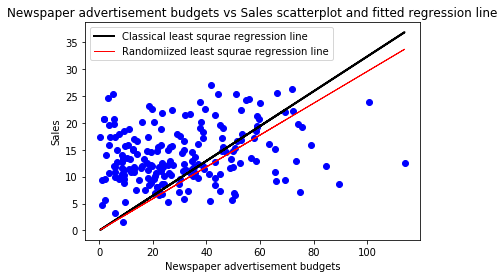

In [51]:
plt.scatter(Newspaper,Sales, color='blue')
plt.plot(Newspaper,np.matmul(Newspaper,x_ls), color='black', linewidth=2,label='Classical least squrae regression line')
plt.plot(Newspaper,np.matmul(Newspaper,x_rls), color='red', linewidth=1,label='Randomiized least squrae regression line')
plt.title('Newspaper advertisement budgets vs Sales scatterplot and fitted regression line')
plt.xlabel('Newspaper advertisement budgets')
plt.ylabel('Sales')
plt.xticks()
plt.yticks()
plt.legend()
plt.savefig('SRHTepsilonNews_point99.png', bbox_inches='tight')
plt.show()

In [52]:
print("The solution by using SRHT sketching on the least square problem is",np.linalg.norm(x_rls-x_ls))

The solution by using SRHT sketching on the least square problem is 0.02777001567721593


For epsilon = 1.2

In [53]:
B=SRHT(Newspaper,Sales,1.2)
x_rls,_,_,_=np.linalg.lstsq(B[0],np.matmul(B[1],B[2]),rcond=None)
residual=np.linalg.norm(np.matmul(Newspaper,x_rls)-Sales)
print("The solution by using SRHT sketching on the least square problem is",x_rls[0][0])
print("The residual due to the use of SRHT sketching on the least square problem is", residual)

The solution by using SRHT sketching on the least square problem is 0.31660915540272655
The residual due to the use of SRHT sketching on the least square problem is 1931.8964418080654


In [54]:
print("The solution by using SRHT sketching on the least square problem is",np.linalg.norm(x_rls-x_ls))

The solution by using SRHT sketching on the least square problem is 0.006592849714799898


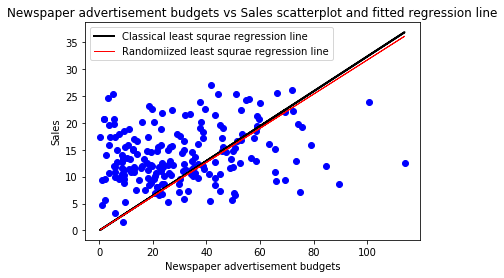

In [55]:
plt.scatter(Newspaper,Sales, color='blue')
plt.plot(Newspaper,np.matmul(Newspaper,x_ls), color='black', linewidth=2,label='Classical least squrae regression line')
plt.plot(Newspaper,np.matmul(Newspaper,x_rls), color='red', linewidth=1,label='Randomiized least squrae regression line')
plt.title('Newspaper advertisement budgets vs Sales scatterplot and fitted regression line')
plt.xlabel('Newspaper advertisement budgets')
plt.ylabel('Sales')
plt.xticks()
plt.yticks()
plt.legend()
plt.savefig('SRHTepsilonNews_1point2.png', bbox_inches='tight')
plt.show()